# Assignment 1 (Autumn 2020)
Module: **COMP30760 Data Science in Python**  
Name: **Rajit Banerjee**  
Student Number: **18202817**  
API(s) used: [Spotify Web API](https://developer.spotify.com/documentation/web-api/)  
Environment: `../environment.yml`  
Collected JSON files: `../data/a1/`

<img src="../images/spotify-logo.jpg">

_Music speaks to the soul._  
Spotify has kept me company through thick and thin, and has helped me get through the past few months. To add a personal touch, I decided to analyse my own Spotify usage over a period of 4 weeks.

## Task 1. Data Indentification and Collection

The Spotify API gives a wide range of interesting data about tracks, podcasts, playlists, artists, users profile, and so on, that can be used to create beautiful visualisations. Every resource (track, artist, etc.) has a unique *base-62 Spotify ID*. For the purposes of this assignment, the focus will be on analysing:
1. My personal top 50 tracks.
2. Top 10 tracks for each of my top artists.

_Note: Kindly only execute the cells marked **# RUN** for Task 1._

In [1]:
# RUN
import json
import os

from pathlib import Path

The API keys for authorizing the use of the Spotify Web API have been stored as *environment variables* for privacy reasons. They are read into variables when access is required. Since the secret API keys are not part of the submission, all the JSON files collected have been saved on disk for later use in Task 2.

In [ ]:
CLIENT_ID = os.environ["SPOTIFY_CLIENT_ID"].strip()
SECRET = os.environ["SPOTIFY_CLIENT_SECRET"].strip()

### 1.1. Web API authorization. 

To get my personal top 50 tracks and artists, the [Implicit Grant Flow](https://developer.spotify.com/documentation/general/guides/authorization-guide/) authorization can be used to obtain the JSON data.

In [ ]:
import webbrowser
import requests


def get_access_token(scopes: str) -> None:
    url = f"https://accounts.spotify.com/authorize?client_id={CLIENT_ID}" + \
        f"&response_type=token&scope={scopes}&redirect_uri=http://localhost/callback/"
    requests.get(url)
    webbrowser.open(url)


get_access_token("user-top-read")

This opens a browser tab where the user must login and authorize _read access_ to their top tracks/artists. Once the authorization is complete, we are redirected to the callback URI, where the access token is present in the address bar (something similar to the image shown below). This "bearer" access token expires after a certain time interval, so it's safe to assign it directly to a variable below.

<img src="../images/access-token.jpg">

In [ ]:
ACCESS_TOKEN = "BQD_YVVFmpNjWGzlx3K5MaxVuonErim7fLD71wAVKu4KUdKrsNCvF28KarctMXa9czJ6AUFXWBIzWiZPJ8T1LeEeDXg_dqzKAxFSanNueIdcY2dpFyG4gtfRmtic3-dZlnErSAhJvkdXQzjf7MRJ7ZE45lgkL57mg3NqfvOQkQw"

Next, to get detailed data for my top artists and tracks, the [Client Credentials Flow](https://developer.spotify.com/documentation/general/guides/authorization-guide/) can be used to access API endpoints that *do not* require user specific information. This authorization flow yields a temporary "basic access" `CLIENT_CRED_TOKEN` which can be stored for later use.

In [ ]:
import base64


def get_token(grant_type: str) -> str:
    auth = base64.b64encode(f"{CLIENT_ID}:{SECRET}".encode()).decode()
    r = requests.post("https://accounts.spotify.com/api/token",
                      data={"grant_type": grant_type},
                      headers={"Authorization": f"Basic {auth}"})
    return r.json()['access_token']


CLIENT_CRED_TOKEN = get_token("client_credentials")

### 1.2. My top tracks & artists.

Using the Implicit Grant access token, data can be collected for my top tracks and artists for a "short term" time range, meaning that Spotify has stored this data based on my **usage over the last 4 weeks**.

In [ ]:
def get_top(type: str = "tracks", limit: int = 50, time_range: str = "short_term") -> None:
    r = requests.get(f"https://api.spotify.com/v1/me/top/{type}?limit={limit}&time_range={time_range}",
                     headers={'Authorization': f'Bearer {ACCESS_TOKEN}'})

    with open(Path(f"../data/a1/my-top-{type}.json"), "wb") as f:
        f.write(r.content)


Path("../data/a1/").mkdir(parents=True, exist_ok=True)
get_top(type="tracks")
get_top(type="artists")

The `data` directory contents can be listed to verify that the JSON files have been stored on disk.

In [2]:
# RUN
for f in Path("../data/a1/").glob("*.json"):
    print(f)

../data/a1/my-top-tracks.json
../data/a1/my-top-artists.json


### 1.3. Audio features for my top 50 tracks.

The Client Credentials access token can now be used to collect more data on the audio features for each of my top tracks.

In [3]:
# RUN
my_top_tracks_path = Path("../data/a1/my-top-tracks.json")
my_top_tracks_features_path = Path("../data/a1/top-tracks-features/")
my_top_tracks_features_path.mkdir(parents=True, exist_ok=True)

In [ ]:
import time


def get_audio_features(track_id: str, path: Path, track_name: str = "") -> None:
    # keep requesting data until response is 200 OK!
    while True:
        r = requests.get(f"https://api.spotify.com/v1/audio-features/{track_id}",
                         headers={"Authorization": f"Bearer {CLIENT_CRED_TOKEN}"})
        if r.status_code == 200:
            break
        print("API rate limit exceeded! Waiting 10 seconds.")
        time.sleep(10)

    if not track_name:
        track_name = track_id
    with open(path/f"{track_name}.json", "wb") as f:
        f.write(r.content)


def get_my_top_tracks_features() -> None:
    top_tracks = json.load(open(my_top_tracks_path, "r"))["items"]
    for track in top_tracks:
        get_audio_features(
            track_id=track["id"], path=my_top_tracks_features_path, track_name=track["name"])


get_my_top_tracks_features()

Audio features are saved in individual JSON files by track name under `top-tracks-features/`.

In [ ]:
# RUN
sorted(my_top_tracks_features_path.iterdir(), key=os.path.getmtime)

### 1.4. My top artists, and their top 10 tracks.

Using the Client Credentials access token again, summary data can be retrieved for the top 10 tracks (**on Spotify Ireland**) for each of my top artists, saved as individual JSON files under `artists-top-tracks/` by the artist name. Then, I'd like to get the audio features for each of the top 10 tracks for each of my top artists. The features for every track (named using its unique Spotify ID) is stored under `artists-top-tracks/audio-features/`, categorised by directories for every individual artist.

In [4]:
# RUN
top_artists_path = Path("../data/a1/my-top-artists.json")
artists_top_tracks_features_path = Path(
    "../data/a1/artists-top-tracks/audio-features/")
summary_path = Path("../data/a1/artists-top-tracks/summary/")
summary_path.mkdir(parents=True, exist_ok=True)

In [ ]:
def get_artists_top_tracks_summary(country: str = "IE") -> None:
    top_artists = json.load(open(top_artists_path, "r"))
    for artist in top_artists["items"]:
        r = requests.get(f"https://api.spotify.com/v1/artists/{artist['id']}/top-tracks?country={country}",
                         headers={"Authorization": f"Bearer {CLIENT_CRED_TOKEN}"})

        with open(summary_path/f"{artist['name']}.json", "wb") as f:
            f.write(r.content)


def get_artists_top_tracks_features() -> None:
    top_artists = json.load(open(top_artists_path, "r"))
    for i in top_artists["items"]:
        artist_name = i["name"]
        artists_top_tracks = json.load(
            open(summary_path/f"{artist_name}.json", "r"))["tracks"]

        for track in artists_top_tracks:
            path = artists_top_tracks_features_path/artist_name
            path.mkdir(parents=True, exist_ok=True)
            get_audio_features(track_id=track["id"], path=path)


get_artists_top_tracks_summary()
get_artists_top_tracks_features()

Display summary JSON files containing details for top 10 tracks, one for each artist.

In [ ]:
# RUN
sorted(summary_path.iterdir(), key=os.path.getmtime)

Display directories for each of my top artists, each containing audio features for 10 top tracks in separate files.

In [ ]:
# RUN
sorted(artists_top_tracks_features_path.iterdir(), key=os.path.getmtime)

## Task 2. Data Preparation

Currently, the following data is stored on disk:
- `../data/a1/`
    - `my-top-tracks.json` (details of my top 50 tracks)
    - `my-top-artists.json` (details of my top artists, 36 in total)
    - `artists-top-tracks/`
        - `audio-features/`
            - (36 directories for my top artists)/
                - (10 JSON files for the top 10 tracks per artist, each containing audio features) 
        - `summary/`
            - (36 JSON files for my top artists, each containing the top 10 tracks' summary for each artist)
    - `top-tracks-features/`
        - (50 JSON files for my top tracks, each containing audio features)
    
Now that all the required data has been stored as JSON (448 different files in total!), we can proceed with the preprocessing steps required before starting analysis of the dataset. All the JSON data described above will be organised and integrated into two DataFrames to be analysed separately:
- `df1`: My top 50 tracks, including all audio features.
- `df2`: Top 10 tracks for each of my top artists, including audio features for each track.

*Note: Please **run all cells** from this point onwards! Kindly ensure that all cells marked # RUN from Task 1 have been executed earlier.*

### 2.1. Organising my top 50 tracks.

Currently, a raw sample entry in the file `my-top-tracks.json` looks like this:

In [5]:
original_tracks = json.load(open(my_top_tracks_path, "r"))
print(original_tracks["items"][0])

{'album': {'album_type': 'ALBUM', 'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/0Ma8KxtvoIDSU5fHtuTS9F'}, 'href': 'https://api.spotify.com/v1/artists/0Ma8KxtvoIDSU5fHtuTS9F', 'id': '0Ma8KxtvoIDSU5fHtuTS9F', 'name': 'The Vogues', 'type': 'artist', 'uri': 'spotify:artist:0Ma8KxtvoIDSU5fHtuTS9F'}], 'available_markets': ['AD', 'AE', 'AR', 'AT', 'AU', 'BE', 'BG', 'BH', 'BO', 'BR', 'CA', 'CH', 'CL', 'CO', 'CR', 'CY', 'CZ', 'DE', 'DK', 'DO', 'DZ', 'EC', 'EE', 'EG', 'ES', 'FI', 'FR', 'GB', 'GR', 'GT', 'HK', 'HN', 'HU', 'ID', 'IE', 'IL', 'IN', 'IS', 'IT', 'JO', 'JP', 'KW', 'LB', 'LI', 'LT', 'LU', 'LV', 'MA', 'MC', 'MT', 'MX', 'MY', 'NI', 'NL', 'NO', 'NZ', 'OM', 'PA', 'PE', 'PH', 'PL', 'PS', 'PT', 'PY', 'QA', 'RO', 'SA', 'SE', 'SG', 'SK', 'SV', 'TH', 'TN', 'TR', 'TW', 'US', 'UY', 'VN', 'ZA'], 'external_urls': {'spotify': 'https://open.spotify.com/album/4mOsuplozzqQGQgk64UXTf'}, 'href': 'https://api.spotify.com/v1/albums/4mOsuplozzqQGQgk64UXTf', 'id': '4mOsuplozzqQGQg

The JSON file data needs to be reformatted before converting it into a pandas DataFrame. Each entry in our reformatted dictionary should be indexed by the track's unique Spotify ID, which can later form the row indices for a DataFrame. We will also extract a few more feature columns from nested objects, such as the track's main artist, album release date and duration in seconds.

In [6]:
from collections import OrderedDict
import datetime


def reformat_tracks(original_tracks: dict) -> OrderedDict():
    res = OrderedDict()
    # songs are sometimes listed under "items", otherwise "tracks"
    first_key = "items" if "items" in original_tracks else "tracks"
    for track in original_tracks[first_key]:
        for k, v in track.items():
            if k != "id":
                if track["id"] not in res:
                    res[track["id"]] = {}
                res[track["id"]][k] = v

        # extract track's primary artist name and add it as a feature
        res[track["id"]]["main_artist"] = track["artists"][0]["name"]

        # extract album release date
        release_date = track["album"]["release_date"]
        if len(release_date) == 4:
            # if only year is provided, make the date 1st of January
            date = datetime.date(int(release_date[:4]), 1, 1)
        else:
            date = datetime.date(int(release_date[:4]), int(
                release_date[5:7]), int(release_date[8:]))
        res[track["id"]]["release_date"] = date

        # convert duration_ms to seconds
        res[track["id"]]["duration_s"] = track["duration_ms"] // 1000

    return res


reformatted_tracks = reformat_tracks(original_tracks)

In [7]:
# display a sample reformatted entry
k, v = next(iter(reformatted_tracks.items()))
print(f"{k}: {v}")
print(f"\nEach track has {len(v)} features.")

6gLtNgs9pUzc10YLx51huD: {'album': {'album_type': 'ALBUM', 'artists': [{'external_urls': {'spotify': 'https://open.spotify.com/artist/0Ma8KxtvoIDSU5fHtuTS9F'}, 'href': 'https://api.spotify.com/v1/artists/0Ma8KxtvoIDSU5fHtuTS9F', 'id': '0Ma8KxtvoIDSU5fHtuTS9F', 'name': 'The Vogues', 'type': 'artist', 'uri': 'spotify:artist:0Ma8KxtvoIDSU5fHtuTS9F'}], 'available_markets': ['AD', 'AE', 'AR', 'AT', 'AU', 'BE', 'BG', 'BH', 'BO', 'BR', 'CA', 'CH', 'CL', 'CO', 'CR', 'CY', 'CZ', 'DE', 'DK', 'DO', 'DZ', 'EC', 'EE', 'EG', 'ES', 'FI', 'FR', 'GB', 'GR', 'GT', 'HK', 'HN', 'HU', 'ID', 'IE', 'IL', 'IN', 'IS', 'IT', 'JO', 'JP', 'KW', 'LB', 'LI', 'LT', 'LU', 'LV', 'MA', 'MC', 'MT', 'MX', 'MY', 'NI', 'NL', 'NO', 'NZ', 'OM', 'PA', 'PE', 'PH', 'PL', 'PS', 'PT', 'PY', 'QA', 'RO', 'SA', 'SE', 'SG', 'SK', 'SV', 'TH', 'TN', 'TR', 'TW', 'US', 'UY', 'VN', 'ZA'], 'external_urls': {'spotify': 'https://open.spotify.com/album/4mOsuplozzqQGQgk64UXTf'}, 'href': 'https://api.spotify.com/v1/albums/4mOsuplozzqQGQgk64UXTf'

Each track contains a dictionary of 19 different features, which we can store in a DataFrame. 

In [8]:
import pandas as pd

df1 = pd.DataFrame.from_dict(reformatted_tracks, orient="index")
cols = df1.columns.tolist()
print(cols, len(cols))

['album', 'artists', 'available_markets', 'disc_number', 'duration_ms', 'explicit', 'external_ids', 'external_urls', 'href', 'is_local', 'name', 'popularity', 'preview_url', 'track_number', 'type', 'uri', 'main_artist', 'release_date', 'duration_s'] 19


Then, it is useful to select the **7 most meaningful features** that can be analysed. Columns `['album', 'artists', 'available_markets', 'disc_number', 'duration_ms', 'external_ids', 'external_urls', 'href', 'is_local', 'preview_url', 'track_number', 'type'] ` will be removed from `df1`.

In [9]:
# reorder 7 selected feature columns to highlight relevant information
selected_cols = ['name', 'main_artist', 'release_date',
                 'uri', 'explicit', 'duration_s', 'popularity']
df1 = df1[selected_cols]

# convert release date to correct type
df1["release_date"] = df1["release_date"].astype("datetime64")

df1.head()

,name,main_artist,release_date,uri,explicit,duration_s,popularity
6gLtNgs9pUzc10YLx51huD,You're the One - Remastered,The Vogues,2020-09-04,spotify:track:6gLtNgs9pUzc10YLx51huD,False,141,14
4AullfDGRGGp4DHyQqIWdG,スターマーカー,KANA-BOON,2020-03-04,spotify:track:4AullfDGRGGp4DHyQqIWdG,False,213,63
7kImuEvUQFbaLfx8f1JFBV,Classy Girl,The Lumineers,2012-01-01,spotify:track:7kImuEvUQFbaLfx8f1JFBV,False,165,48
5CuQUbas6KGKtHCZfNG7wY,"December, 1963 (Oh, What a Night) - 2007 Remaster",Frankie Valli & The Four Seasons,2007-06-04,spotify:track:5CuQUbas6KGKtHCZfNG7wY,False,213,45
09x9v1o51dbqi5H0u7UGfp,I Will - Remastered 2009,The Beatles,1968-11-22,spotify:track:09x9v1o51dbqi5H0u7UGfp,False,105,63


Next, we need to include the audio features for each of the top 50 tracks to our DataFrame. This data was stored under `top-tracks-features/` earlier. Every JSON file in this directory has 18 simple key-value pairs, out of which we only need the 12. The remaining 6 columns `['type', 'id', 'uri', 'track_href', 'analysis_url', 'duration_ms']` will be avoided since this information is redundant or duplicate, for the purpose of analysis later.

In [10]:
def insert_audio_features(df: pd.DataFrame, path: Path) -> pd.DataFrame:
    copy = df.copy(deep=True)
    for filename in os.listdir(path):
        features = json.load(open(path/filename, 'r'))
        for k, v in features.items():
            if k not in ["type", "id", "uri", "track_href", "analysis_url", "duration_ms"]:
                copy.loc[features["id"], k] = v
    return copy


df1 = insert_audio_features(df1, path=my_top_tracks_features_path)
df1.head()

,name,main_artist,release_date,uri,explicit,duration_s,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
6gLtNgs9pUzc10YLx51huD,You're the One - Remastered,The Vogues,2020-09-04,spotify:track:6gLtNgs9pUzc10YLx51huD,False,141,14,0.440,0.747,10.0,-5.883,1.0,0.0405,0.6150,0.000000,0.7120,0.942,142.113,4.0
4AullfDGRGGp4DHyQqIWdG,スターマーカー,KANA-BOON,2020-03-04,spotify:track:4AullfDGRGGp4DHyQqIWdG,False,213,63,0.502,0.846,4.0,-3.196,1.0,0.0422,0.0194,0.000000,0.3020,0.767,134.041,4.0
7kImuEvUQFbaLfx8f1JFBV,Classy Girl,The Lumineers,2012-01-01,spotify:track:7kImuEvUQFbaLfx8f1JFBV,False,165,48,0.722,0.799,0.0,-7.636,1.0,0.0354,0.6770,0.000018,0.3460,0.485,121.029,4.0
5CuQUbas6KGKtHCZfNG7wY,"December, 1963 (Oh, What a Night) - 2007 Remaster",Frankie Valli & The Four Seasons,2007-06-04,spotify:track:5CuQUbas6KGKtHCZfNG7wY,False,213,45,0.708,0.670,1.0,-7.596,1.0,0.0294,0.0918,0.000004,0.0408,0.920,104.522,4.0
09x9v1o51dbqi5H0u7UGfp,I Will - Remastered 2009,The Beatles,1968-11-22,spotify:track:09x9v1o51dbqi5H0u7UGfp,False,105,63,0.631,0.387,5.0,-11.529,1.0,0.0262,0.7420,0.000406,0.0822,0.832,103.110,4.0


In [11]:
df1.shape

(50, 19)

As we can see above, our `df1` now has 12 extra columns, bringing the total to 19 features per row. We finally have our DataFrame ready to be analysed.

### 2.2. Top artists need to be organised too!

Next, we will move on to preparing `df2`, the DataFrame containing the top 10 tracks for each of my top artists, including the audio features for each track. The artist-specific data in `my-top-artists.json` won't really be used here, since its purpose was only to find out who my top artists were, so that more data on each of their top 10 tracks could be collected. The focus will be on integrating the files in the `artists-top-tracks/` directory into the DataFrame `df2`.

In [12]:
# concatenate DataFrames for each of the 36 reformatted JSON files under `artists-top-tracks/summary/`
df2 = pd.concat([pd.DataFrame.from_dict(
    reformat_tracks(json.load(open(path, "r"))),
    orient="index")
    for path in sorted(summary_path.iterdir(), key=os.path.getmtime)])

# convert release date to correct type
df2["release_date"] = df2["release_date"].astype("datetime64")
df2.head()

,album,artists,disc_number,duration_ms,explicit,external_ids,external_urls,href,is_local,is_playable,name,popularity,preview_url,track_number,type,uri,main_artist,release_date,duration_s
5KCbr5ndeby4y4ggthdiAb,"{'album_type': 'single', 'artists': [{'externa...",[{'external_urls': {'spotify': 'https://open.s...,1,172692,False,{'isrc': 'USUM72018522'},{'spotify': 'https://open.spotify.com/track/5K...,https://api.spotify.com/v1/tracks/5KCbr5ndeby4...,False,True,Wonder,92,None,1,track,spotify:track:5KCbr5ndeby4y4ggthdiAb,Shawn Mendes,2020-10-02,172
6v3KW9xbzN5yKLt9YKDYA2,"{'album_type': 'album', 'artists': [{'external...",[{'external_urls': {'spotify': 'https://open.s...,1,190799,False,{'isrc': 'USUM71911283'},{'spotify': 'https://open.spotify.com/track/6v...,https://api.spotify.com/v1/tracks/6v3KW9xbzN5y...,False,True,Señorita,82,None,1,track,spotify:track:6v3KW9xbzN5yKLt9YKDYA2,Shawn Mendes,2019-06-19,190
3QGsuHI8jO1Rx4JWLUh9jd,"{'album_type': 'album', 'artists': [{'external...",[{'external_urls': {'spotify': 'https://open.s...,1,187973,False,{'isrc': 'USUM71604711'},{'spotify': 'https://open.spotify.com/track/3Q...,https://api.spotify.com/v1/tracks/3QGsuHI8jO1R...,False,True,Treat You Better,82,None,4,track,spotify:track:3QGsuHI8jO1Rx4JWLUh9jd,Shawn Mendes,2017-04-20,187
7JJmb5XwzOO8jgpou264Ml,"{'album_type': 'album', 'artists': [{'external...",[{'external_urls': {'spotify': 'https://open.s...,1,199440,False,{'isrc': 'USUM71702833'},{'spotify': 'https://open.spotify.com/track/7J...,https://api.spotify.com/v1/tracks/7JJmb5XwzOO8...,False,True,There's Nothing Holdin' Me Back,81,None,1,track,spotify:track:7JJmb5XwzOO8jgpou264Ml,Shawn Mendes,2017-04-20,199
2bT1PH7Cw3J9p3t7nlXCdh,"{'album_type': 'album', 'artists': [{'external...",[{'external_urls': {'spotify': 'https://open.s...,1,191466,False,{'isrc': 'USUM71907349'},{'spotify': 'https://open.spotify.com/track/2b...,https://api.spotify.com/v1/tracks/2bT1PH7Cw3J9...,False,True,If I Can't Have You,76,None,3,track,spotify:track:2bT1PH7Cw3J9p3t7nlXCdh,Shawn Mendes,2019-06-19,191


In [13]:
df2.shape

(360, 19)

As expected, we have 36 artists x 10 top tracks = 360 rows, and 19 feature columns for each track. Next, we need to select and reorder the 7 important columns as before, then integrate the 12 additional audio features for each of the 360 tracks, from the files under `artists-top-tracks/audio-features/`.

In [14]:
df2 = df2[selected_cols]

parent = artists_top_tracks_features_path
for dir in os.listdir(parent):
    df2 = insert_audio_features(df2, parent/dir)

df2.head()

,name,main_artist,release_date,uri,explicit,duration_s,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
5KCbr5ndeby4y4ggthdiAb,Wonder,Shawn Mendes,2020-10-02,spotify:track:5KCbr5ndeby4y4ggthdiAb,False,172,92,0.333,0.637,1.0,-4.904,0.0,0.0581,0.1310,0.000018,0.1490,0.132,139.898,4.0
6v3KW9xbzN5yKLt9YKDYA2,Señorita,Shawn Mendes,2019-06-19,spotify:track:6v3KW9xbzN5yKLt9YKDYA2,False,190,82,0.759,0.548,9.0,-6.049,0.0,0.0290,0.0392,0.000000,0.0828,0.749,116.967,4.0
3QGsuHI8jO1Rx4JWLUh9jd,Treat You Better,Shawn Mendes,2017-04-20,spotify:track:3QGsuHI8jO1Rx4JWLUh9jd,False,187,82,0.444,0.819,10.0,-4.078,0.0,0.3410,0.1060,0.000000,0.1070,0.747,82.695,4.0
7JJmb5XwzOO8jgpou264Ml,There's Nothing Holdin' Me Back,Shawn Mendes,2017-04-20,spotify:track:7JJmb5XwzOO8jgpou264Ml,False,199,81,0.866,0.813,11.0,-4.063,0.0,0.0554,0.3800,0.000000,0.0779,0.969,121.998,4.0
2bT1PH7Cw3J9p3t7nlXCdh,If I Can't Have You,Shawn Mendes,2019-06-19,spotify:track:2bT1PH7Cw3J9p3t7nlXCdh,False,191,76,0.691,0.823,2.0,-4.197,1.0,0.0623,0.4870,0.000000,0.1340,0.870,123.935,4.0


Great! We now have both DataFrames `df1` and `df2` ready for characterisation and analysis.

## Task 3. Data Analysis

A key aspect of Data Science is the art of _storytelling_. This task's focus will be to ask some interesting questions about the data collected and organised so far, in an attempt to build a story around it. The two DataFrames to be analysed are `df1` and `df2`.

### 3.1. My top 50 tracks, in tables and plots.

#### (i) What were my top tracks over the last 4 weeks?

Let's begin our story with `df1`, which contains data about my top 50 tracks on Spotify, roughly for the last 4 weeks. 

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

The top 5 tracks are shown below.

In [16]:
df1.head()

,name,main_artist,release_date,uri,explicit,duration_s,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
6gLtNgs9pUzc10YLx51huD,You're the One - Remastered,The Vogues,2020-09-04,spotify:track:6gLtNgs9pUzc10YLx51huD,False,141,14,0.440,0.747,10.0,-5.883,1.0,0.0405,0.6150,0.000000,0.7120,0.942,142.113,4.0
4AullfDGRGGp4DHyQqIWdG,スターマーカー,KANA-BOON,2020-03-04,spotify:track:4AullfDGRGGp4DHyQqIWdG,False,213,63,0.502,0.846,4.0,-3.196,1.0,0.0422,0.0194,0.000000,0.3020,0.767,134.041,4.0
7kImuEvUQFbaLfx8f1JFBV,Classy Girl,The Lumineers,2012-01-01,spotify:track:7kImuEvUQFbaLfx8f1JFBV,False,165,48,0.722,0.799,0.0,-7.636,1.0,0.0354,0.6770,0.000018,0.3460,0.485,121.029,4.0
5CuQUbas6KGKtHCZfNG7wY,"December, 1963 (Oh, What a Night) - 2007 Remaster",Frankie Valli & The Four Seasons,2007-06-04,spotify:track:5CuQUbas6KGKtHCZfNG7wY,False,213,45,0.708,0.670,1.0,-7.596,1.0,0.0294,0.0918,0.000004,0.0408,0.920,104.522,4.0
09x9v1o51dbqi5H0u7UGfp,I Will - Remastered 2009,The Beatles,1968-11-22,spotify:track:09x9v1o51dbqi5H0u7UGfp,False,105,63,0.631,0.387,5.0,-11.529,1.0,0.0262,0.7420,0.000406,0.0822,0.832,103.110,4.0


Now, let's retrieve some more information about our DataFrame entries, and look for any missing data.

In [17]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, 6gLtNgs9pUzc10YLx51huD to 2BY7ALEWdloFHgQZG6VMLA
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   name              50 non-null     object        
 1   main_artist       50 non-null     object        
 2   release_date      50 non-null     datetime64[ns]
 3   uri               50 non-null     object        
 4   explicit          50 non-null     bool          
 5   duration_s        50 non-null     int64         
 6   popularity        50 non-null     int64         
 7   danceability      50 non-null     float64       
 8   energy            50 non-null     float64       
 9   key               50 non-null     float64       
 10  loudness          50 non-null     float64       
 11  mode              50 non-null     float64       
 12  speechiness       50 non-null     float64       
 13  acousticness      50 non-null     float64     

- As we can see, there are 50 rows for 50 tracks.
- Each track has 19 features that were organised in Task 2.1.
- The audio features (#7 to #18) look fascinating, they need to be looked at further.
- There is no missing data!

We can also generate descriptive statistics like the mean, quartiles, range, standard deviation, etc., for features containing numerical data.

In [18]:
df1.describe()

,duration_s,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
count,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,207.980000,57.380000,0.579900,0.510210,4.440000,-10.029360,0.840000,0.045028,0.498013,0.044020,0.221338,0.532626,124.186980,3.920000
std,55.124901,15.880793,0.141222,0.210363,3.828785,2.822042,0.370328,0.029895,0.333188,0.154833,0.194265,0.256685,25.316025,0.274048
min,105.000000,3.000000,0.330000,0.065000,0.000000,-16.070000,0.000000,0.026200,0.000942,0.000000,0.040800,0.072400,70.838000,3.000000
25%,163.250000,49.000000,0.455000,0.344750,0.250000,-11.608500,1.000000,0.031125,0.143250,0.000010,0.094100,0.298000,113.535500,4.000000
50%,193.500000,57.000000,0.566000,0.527000,4.500000,-9.699500,1.000000,0.034800,0.575000,0.000648,0.147000,0.544500,125.464500,4.000000
75%,255.750000,69.000000,0.701500,0.648750,7.000000,-7.815000,1.000000,0.042350,0.790500,0.008510,0.272500,0.755000,139.272750,4.000000
max,327.000000,90.000000,0.837000,0.969000,11.000000,-3.196000,1.000000,0.176000,0.989000,0.869000,0.970000,0.975000,190.187000,4.000000


#### (ii) How popular are my top tracks with other people?

According to Spotify, _"the **popularity** of a track is a value between 0 and 100, with 100 being the most popular. The popularity is calculated by algorithm and is based, in the most part, on the total number of plays the track has had and how recent those plays are. Generally speaking, songs that are being played a lot now will have a higher popularity than songs that were played a lot in the past."_

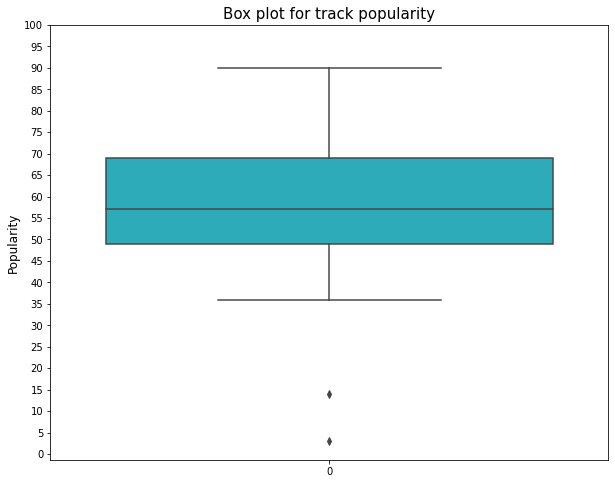

In [19]:
plt.figure(figsize=(10, 8))
sns.boxplot(data=df1["popularity"], color="tab:cyan")
plt.title("Box plot for track popularity", fontsize=15)
plt.ylabel("Popularity", fontsize=12)
plt.yticks(range(0, 101, 5))
plt.show()

The popularity of my tracks is summarised by a box and whisker plot above, which shows a 5-point summary:
- Lower extreme (around 35)
- Lower quartile (around 50)
- Median (between 55 and 60)
- Upper quartile (almost 70)
- Upper extreme (almost 90)

The plot also shows points that it classifies as outliers (signifying some unpopular songs in this particular case).

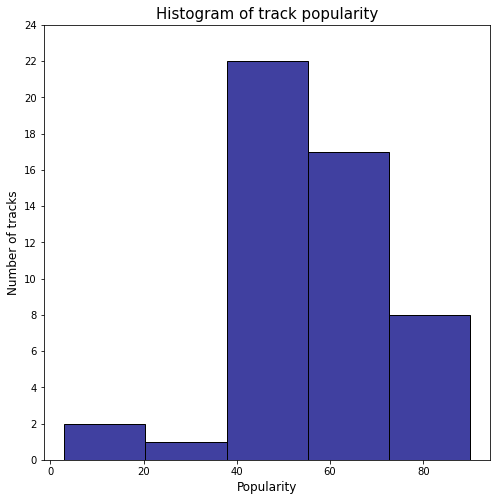

In [20]:
plt.figure(figsize=(8, 8))
sns.histplot(data=df1, x="popularity", bins=5, color="navy")
plt.title("Histogram of track popularity", fontsize=15)
plt.xlabel("Popularity", fontsize=12)
plt.ylabel("Number of tracks", fontsize=12)
plt.yticks(range(0, 25, 2))
plt.show()

In [21]:
df1["popularity"].describe()

count    50.000000
mean     57.380000
std      15.880793
min       3.000000
25%      49.000000
50%      57.000000
75%      69.000000
max      90.000000
Name: popularity, dtype: float64

Both the mean and median popularity score of my top 50 tracks are not too high (57/100).   
This suggests that some of the songs I enjoy listening to are still undiscovered by a lot of people!

#### (iii) How long are my top tracks?

What does the distribution look like for the duration of my top tracks?

In [22]:
df1["duration_s"].describe()

count     50.000000
mean     207.980000
std       55.124901
min      105.000000
25%      163.250000
50%      193.500000
75%      255.750000
max      327.000000
Name: duration_s, dtype: float64

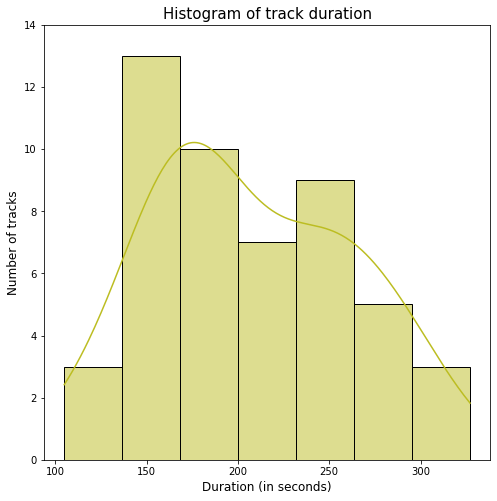

In [23]:
plt.figure(figsize=(8, 8))
sns.histplot(data=df1, x="duration_s", color="tab:olive", kde=True)
plt.title("Histogram of track duration", fontsize=15)
plt.xlabel("Duration (in seconds)", fontsize=12)
plt.ylabel("Number of tracks", fontsize=12)
plt.yticks(range(0, 15, 2))
plt.show()

The highest peak is around the 150 second mark, suggesting that mode of the distribution is  2$\frac{1}{2}$ minutes.

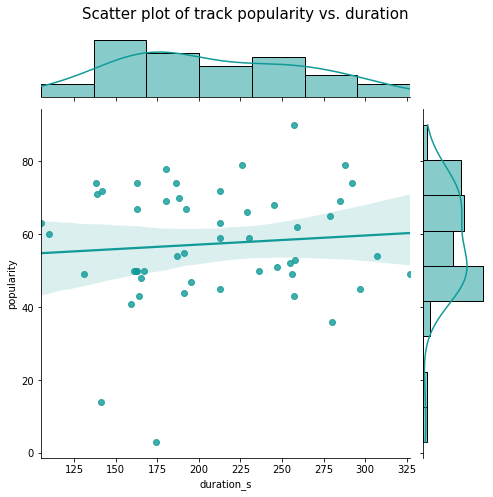

In [24]:
p = sns.jointplot(x="duration_s", y="popularity", kind="reg",
                  data=df1, height=7, color="#109A98")
p.fig.suptitle("Scatter plot of track popularity vs. duration", fontsize=15)
p.fig.subplots_adjust(top=0.92)  # reduce plot to make room
plt.xlabel("Duration (in seconds)", fontsize=12)
plt.ylabel("Popularity", fontsize=12)
plt.show()

- The correlation between track duration and popularity is quite weak, as suggested by the scatter plot and regression line above.
- This means that the length of a track is expected to have negligible effect on its popularity.

#### (iv) What are these audio features that Spotify measures for every track?
Let's take a look at pairwise correlation for the 12 audio features that Spotify gives us for every track. The track popularity and duration in seconds have also been included to check if they are correlated to audio features.

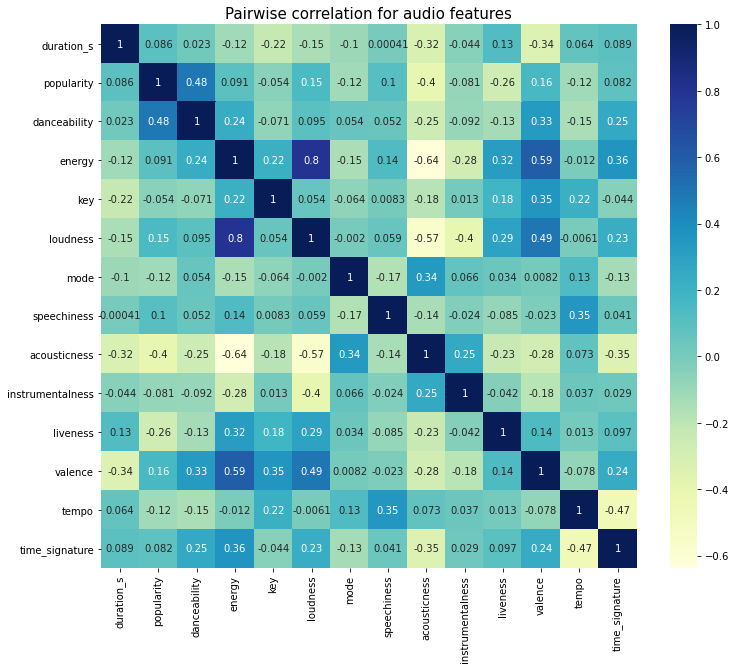

In [25]:
plt.figure(figsize=(12, 10))
sns.heatmap(df1.iloc[:, 5:].corr(), annot=True, cmap="YlGnBu")
plt.title("Pairwise correlation for audio features", fontsize=15)
plt.show()

_Beautiful._ We can infer the following from the heat map for our smaller DataFrame `df1` as shown above:
- Energy and loudness have a strong positive correlation of 0.8.
- Energy and valence also have a moderate positive correlation of 0.59.

This makes sense because loud songs are usually considered "energetic".  
Similarly, more energetic songs are shown to have a high valence score, as they tend to sound more positive (happy/cheerful).

- As a consequence of the nature of the two observations above, loudness and valence also have a weak positive correlation of 0.49.
- There also seems be a weak positive correlation of 0.48 between popularity and danceability.
- Acousticness has a moderately strong negative correlation with energy (-0.64) and loudness (-0.57), as well as a weak negative correlation with popularity (-0.4).

It looks like more "danceable" songs tend to be popular on Spotify! Moreover, for some reason, more "acoustic" songs aren't that popular.


We will take another look at the correlation between audio features later with our larger DataFrame `df2`.

#### (v) When were my top tracks released?

Let's try to plot the number of tracks released over the years.

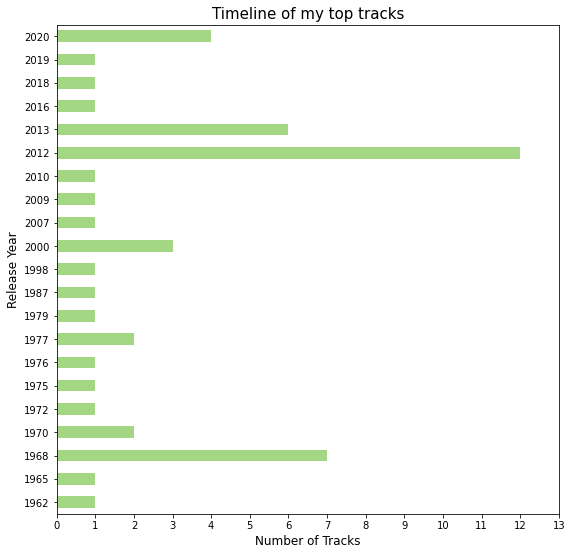

In [26]:
plt.figure(figsize=(9, 9))
df1["release_date"].groupby(df1["release_date"].dt.year).count().plot(
    kind="barh", color="#A3D783")
plt.title("Timeline of my top tracks", fontsize=15)
plt.xlabel("Number of Tracks", fontsize=12)
plt.ylabel("Release Year", fontsize=12)
plt.xticks(range(0, 14))
plt.show()

- The above plot shows my top tracks, grouped by the release year. 
- It's not an error-free distribution, since a thorough look at our DataFrame reveals that certain old songs which have been remastered, have been assigned the release date of the remastered album, instead of the original song's release date. 
- However, the plot still provides some indication regarding the _age_ of my tracks. 
- There's a good few tracks from the late 1960's, primarily thanks to John, Paul, George and Ringo.
- The rest of the tracks mostly lie in the early 2010's.


#### (vi) Who are the main artists for my top tracks?

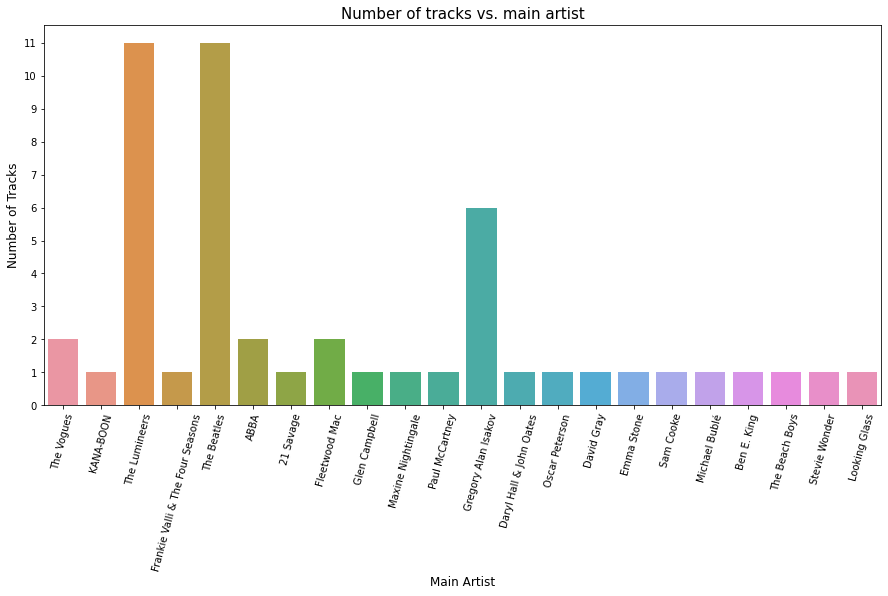

In [27]:
plt.figure(figsize=(15, 7))
sns.countplot(x="main_artist", data=df1)
plt.title("Number of tracks vs. main artist", fontsize=15)
plt.xlabel("Main Artist", fontsize=12)
plt.ylabel("Number of Tracks", fontsize=12)
plt.xticks(rotation=75)
plt.yticks(range(12))
plt.show()

We can see that The Beatles and The Lumineers lead the way with 11 appearances each! Gregory Alan Isakov comes in next with 6 tracks in my top 50. Indeed, I have been listening to these artists quite often over the past few weeks! The remaining artists all have either 1 or 2 tracks each in my top 50, which suggests that I like those individual songs, possibly more than the other songs the artists might have.

### 3.2. Top tracks from my top artists, visualised.

Let's proceed with exploring our larger DataFrame `df2` containing the top 10 tracks (on Spotify Ireland, not worldwide) from each of my top (36) artists.

#### (i) What are my top artists' top tracks?

In [28]:
df2.head()

,name,main_artist,release_date,uri,explicit,duration_s,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
5KCbr5ndeby4y4ggthdiAb,Wonder,Shawn Mendes,2020-10-02,spotify:track:5KCbr5ndeby4y4ggthdiAb,False,172,92,0.333,0.637,1.0,-4.904,0.0,0.0581,0.1310,0.000018,0.1490,0.132,139.898,4.0
6v3KW9xbzN5yKLt9YKDYA2,Señorita,Shawn Mendes,2019-06-19,spotify:track:6v3KW9xbzN5yKLt9YKDYA2,False,190,82,0.759,0.548,9.0,-6.049,0.0,0.0290,0.0392,0.000000,0.0828,0.749,116.967,4.0
3QGsuHI8jO1Rx4JWLUh9jd,Treat You Better,Shawn Mendes,2017-04-20,spotify:track:3QGsuHI8jO1Rx4JWLUh9jd,False,187,82,0.444,0.819,10.0,-4.078,0.0,0.3410,0.1060,0.000000,0.1070,0.747,82.695,4.0
7JJmb5XwzOO8jgpou264Ml,There's Nothing Holdin' Me Back,Shawn Mendes,2017-04-20,spotify:track:7JJmb5XwzOO8jgpou264Ml,False,199,81,0.866,0.813,11.0,-4.063,0.0,0.0554,0.3800,0.000000,0.0779,0.969,121.998,4.0
2bT1PH7Cw3J9p3t7nlXCdh,If I Can't Have You,Shawn Mendes,2019-06-19,spotify:track:2bT1PH7Cw3J9p3t7nlXCdh,False,191,76,0.691,0.823,2.0,-4.197,1.0,0.0623,0.4870,0.000000,0.1340,0.870,123.935,4.0


In [29]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 360 entries, 5KCbr5ndeby4y4ggthdiAb to 69uxyAqqPIsUyTO8txoP2M
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   name              360 non-null    object        
 1   main_artist       360 non-null    object        
 2   release_date      360 non-null    datetime64[ns]
 3   uri               360 non-null    object        
 4   explicit          360 non-null    bool          
 5   duration_s        360 non-null    int64         
 6   popularity        360 non-null    int64         
 7   danceability      360 non-null    float64       
 8   energy            360 non-null    float64       
 9   key               360 non-null    float64       
 10  loudness          360 non-null    float64       
 11  mode              360 non-null    float64       
 12  speechiness       360 non-null    float64       
 13  acousticness      360 non-null    float64    

- As we can see, there are 360 rows for 36 x 10 tracks.
- Each track has 19 features that were organised in Task 2.2.
- We have the same audio features like Task 3.1, but this time our DataFrame is much larger. Will there be any new correlation visible?
- There is no missing data!

As before, we can generate descriptive statistics like the mean, quartiles, range, standard deviation, etc., for features containing numerical data.

In [30]:
df2.describe()

,duration_s,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
count,360.000000,360.000000,360.000000,360.000000,360.000000,360.000000,360.000000,360.000000,360.000000,360.000000,360.000000,360.000000,360.000000,360.000000
mean,237.958333,65.855556,0.570636,0.554001,4.777778,-8.808097,0.747222,0.054502,0.374508,0.061396,0.155083,0.459037,119.728328,3.916667
std,94.550017,13.443215,0.144648,0.219199,3.492221,4.457167,0.435209,0.054477,0.330238,0.197868,0.116185,0.233594,28.060679,0.363747
min,110.000000,20.000000,0.129000,0.017200,0.000000,-27.331000,0.000000,0.023200,0.000023,0.000000,0.032900,0.039200,49.689000,1.000000
25%,197.750000,58.000000,0.482000,0.396000,1.750000,-10.499750,0.000000,0.031300,0.063075,0.000000,0.091000,0.282750,97.953000,4.000000
50%,223.000000,66.000000,0.581000,0.576000,5.000000,-7.872500,1.000000,0.037900,0.254000,0.000008,0.112000,0.423000,118.585000,4.000000
75%,261.000000,77.000000,0.675000,0.727000,7.000000,-5.815500,1.000000,0.051750,0.696250,0.001978,0.166250,0.629250,137.988500,4.000000
max,1561.000000,94.000000,0.912000,0.970000,11.000000,-2.260000,1.000000,0.498000,0.995000,0.935000,0.760000,0.972000,205.895000,5.000000


In [31]:
df2["main_artist"].value_counts()

One Direction          10
Shawn Mendes           10
Gregory Alan Isakov    10
Vance Joy              10
Mumford & Sons         10
                       ..
Jasleen Royal           1
Darshan Raval           1
Leon Bridges            1
Lady Gaga               1
Ankur Tewari            1
Name: main_artist, Length: 63, dtype: int64

Each artist was expected to appear 10 times, since we requested the top 10 tracks for every artist. However, counting the number of appearances of main artists above reveals that some artists have appeared only once. Why could this be? Most likely, this is a result of songs having multiple artists, but while extracting the `main_artist`, only the _first_ artist from the list was selected.

#### (ii) How does the popularity of top artists vary?

In [32]:
top_artists_tracks = df2.groupby("main_artist")
top_artists_tracks.mean()

,explicit,duration_s,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature
main_artist,,,,,,,,,,,,,,,
A.R. Rahman,0.0,251.666667,64.00,0.553556,0.467444,4.888889,-10.074000,0.555556,0.054722,0.50690,2.120478e-04,0.147789,0.482778,109.965778,3.888889
Akhil Sachdeva,0.0,265.000000,63.00,0.607000,0.515000,7.000000,-9.401000,1.000000,0.029900,0.21600,2.650000e-04,0.314000,0.283000,97.947000,4.000000
Alok,0.0,179.000000,61.00,0.611000,0.835000,6.000000,-4.107000,1.000000,0.139000,0.16700,0.000000e+00,0.107000,0.672000,102.023000,4.000000
Amaal Mallik,0.0,259.000000,56.00,0.803000,0.931000,1.000000,-2.471000,0.000000,0.055400,0.01590,3.070000e-05,0.318000,0.756000,130.041000,4.000000
Ami Mishra,0.0,192.000000,58.00,0.520000,0.485000,4.000000,-6.438000,0.000000,0.026900,0.92700,4.660000e-04,0.159000,0.407000,143.901000,4.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
The Lumineers,0.0,192.800000,63.90,0.597700,0.550200,6.100000,-8.591700,1.000000,0.033180,0.59700,2.001670e-03,0.123050,0.414400,109.091000,4.000000
The Vamps,0.0,193.250000,66.75,0.615500,0.760250,5.125000,-5.146875,0.625000,0.052200,0.03976,3.050000e-07,0.160025,0.580750,123.614250,4.000000
The Vogues,0.0,154.400000,32.20,0.356900,0.519100,5.300000,-9.620500,1.000000,0.033570,0.54920,7.448610e-03,0.192430,0.540900,136.890900,3.700000


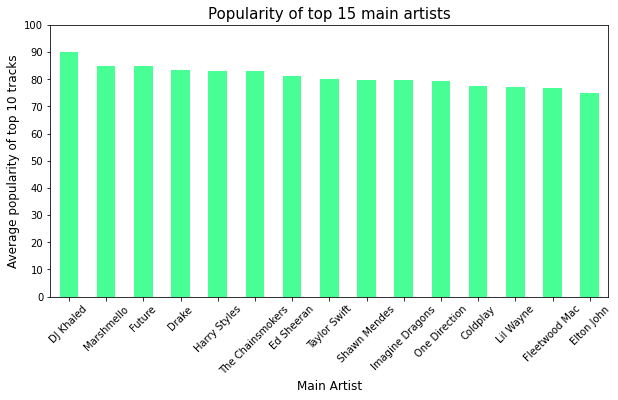

In [33]:
plt.figure(figsize=(10, 5))
top_artists_tracks.mean()["popularity"].sort_values(
    ascending=False).head(15).plot(kind="bar", color="#48FF95")
plt.title("Popularity of top 15 main artists", fontsize=15)
plt.xlabel("Main Artist", fontsize=12)
plt.ylabel("Average popularity of top 10 tracks", fontsize=12)
plt.xticks(rotation=45)
plt.yticks(range(0, 101, 10))
plt.show()

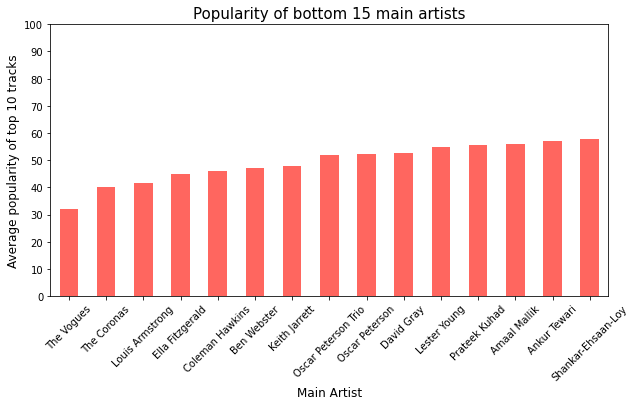

In [34]:
plt.figure(figsize=(10, 5))
top_artists_tracks.mean()["popularity"].sort_values().head(
    15).plot(kind="bar", color="#FF665F")
plt.title("Popularity of bottom 15 main artists", fontsize=15)
plt.xlabel("Main Artist", fontsize=12)
plt.ylabel("Average popularity of top 10 tracks", fontsize=12)
plt.xticks(rotation=45)
plt.yticks(range(0, 101, 10))
plt.show()

The two plots above show the popularity distribution of the top 15 and the bottom 15 main artists from my list of top artists. The artists' popularity score is calculated as the average popularity of their top 10 tracks on Spotify Ireland.  

#### (iii) Timeline of tracks' release

Let's see how the dates of release of an artist's top 10 tracks have an effect on their popularity and relevance.

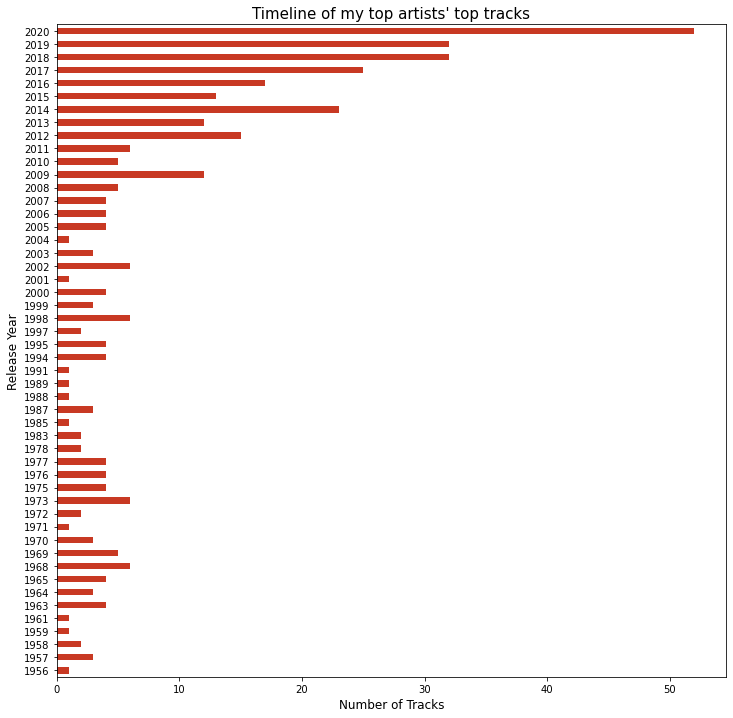

In [35]:
plt.figure(figsize=(12, 12))
df2["release_date"].groupby(df2["release_date"].dt.year).count().plot(
    kind="barh", color="#C83923")
plt.title("Timeline of my top artists' top tracks", fontsize=15)
plt.xlabel("Number of Tracks", fontsize=12)
plt.ylabel("Release Year", fontsize=12)
plt.show()

As expected, we can infer the following:
- The majority of current top 10 tracks of my top artists are bound to be the more recently released ones (mostly in the last 5 years, with over 50 of them in 2020 itself).
- One can guess that Spotify users are more likely to listen to new music released by an active artist, which is a plausible reason for the maximum number of tracks from 2020.
- However, there are still some tracks that are a few decades old, possibly because the artists no longer release new music.

#### (iv) Audio features, revisited.


Next, we can take a deeper look at the individual distributions for the 12 audio features that we get from each of the 360 tracks in the DataFrame. We look to the Spotify API to provide details regarding the meaning of these features, that we briefly explored earlier in Task 3.1.

_**Danceability** describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable._

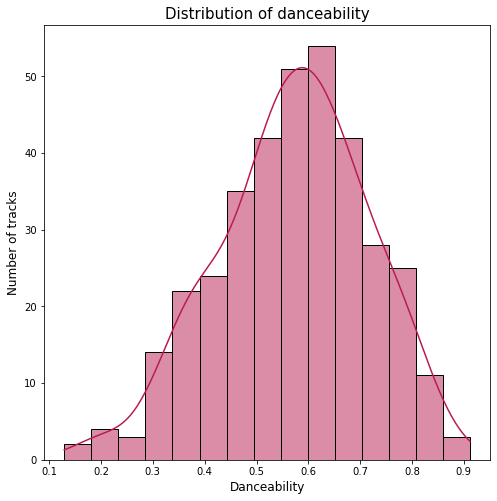

In [36]:
plt.figure(figsize=(8, 8))
sns.histplot(data=df2, x="danceability", color="#B81C50", kde=True)
plt.title("Distribution of danceability", fontsize=15)
plt.xlabel("Danceability", fontsize=12)
plt.ylabel("Number of tracks", fontsize=12)
plt.show()

Danceability almost completely follows a normal distribution, with only a slight skew to the right.

_**Energy** is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy._

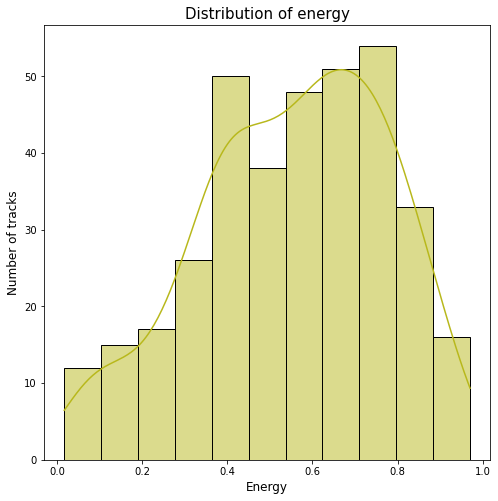

In [37]:
plt.figure(figsize=(8, 8))
sns.histplot(data=df2, x="energy", color="#B8B81C", kde=True)
plt.title("Distribution of energy", fontsize=15)
plt.xlabel("Energy", fontsize=12)
plt.ylabel("Number of tracks", fontsize=12)
plt.show()

Most of the top tracks from my top artists' appear to have a moderate to high level of energy.

**Key** is the _estimated overall key of the track. Integers map to pitches using standard Pitch Class notation . E.g. 0 = C, 1 = C♯/D♭, 2 = D, and so on. If no key was detected, the value is -1._

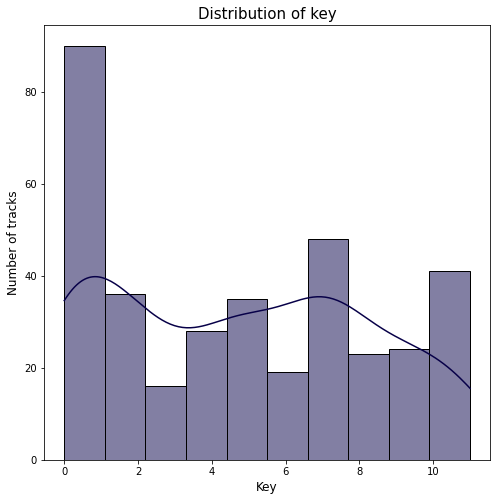

In [38]:
plt.figure(figsize=(8, 8))
sns.histplot(data=df2, x="key", color="#070048", kde=True)
plt.title("Distribution of key", fontsize=15)
plt.xlabel("Key", fontsize=12)
plt.ylabel("Number of tracks", fontsize=12)
plt.show()

A key between 0 and 1 (approx.) is most common, which suggests that a large number of tracks are in the key of C or C#.

**Loudness** is the _overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typical range between -60 and 0 db._

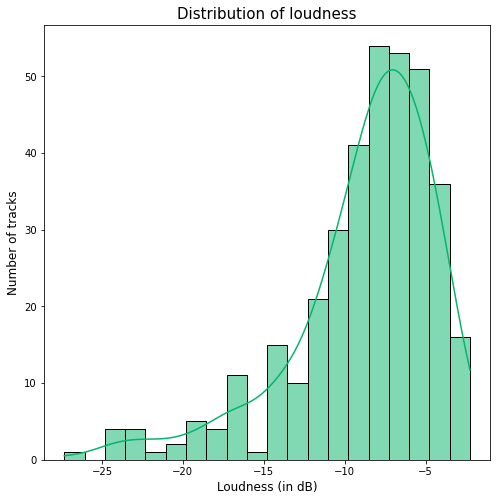

In [39]:
plt.figure(figsize=(8, 8))
sns.histplot(data=df2, x="loudness", color="#04B56B", kde=True)
plt.title("Distribution of loudness", fontsize=15)
plt.xlabel("Loudness (in dB)", fontsize=12)
plt.ylabel("Number of tracks", fontsize=12)
plt.show()

The distribution is heavily skewed to the right, which suggests that the majority of tracks tend to be on the louder side.

_**Mode** indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived.  
Major is represented by 1 and minor is 0._

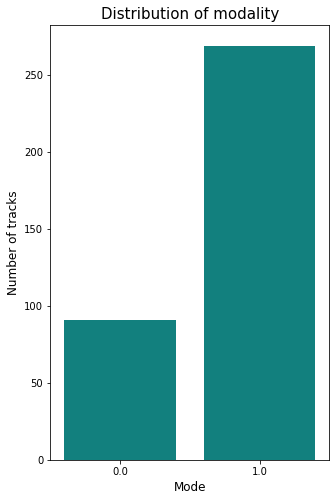

In [40]:
plt.figure(figsize=(5, 8))
sns.countplot(x="mode", data=df2, color="#00928F")
plt.title("Distribution of modality", fontsize=15)
plt.xlabel("Mode", fontsize=12)
plt.ylabel("Number of tracks", fontsize=12)
plt.show()

In [41]:
df2["mode"].value_counts()

1.0    269
0.0     91
Name: mode, dtype: int64

The plot clearly shows that the number of tracks in a major scale (1) is far greater than those in a minor scale (0). This tends to be true in general, since tracks in a major scale usually sound more pleasant to the human ear.

_**Speechiness** detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks._

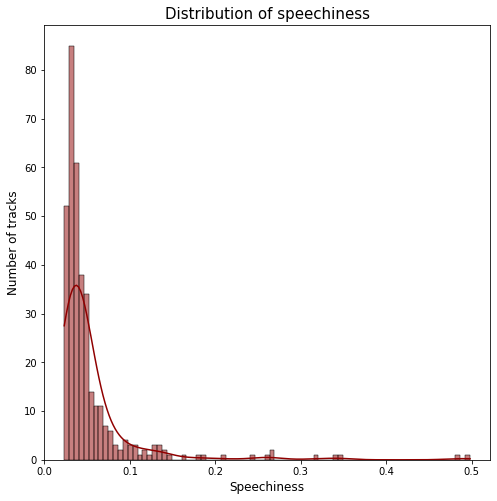

In [42]:
plt.figure(figsize=(8, 8))
sns.histplot(data=df2, x="speechiness", color="#900000", kde=True)
plt.title("Distribution of speechiness", fontsize=15)
plt.xlabel("Speechiness", fontsize=12)
plt.ylabel("Number of tracks", fontsize=12)
plt.show()

Since all the tracks here are music, the distribution above follows expectations, with the large majority of tracks having a speechiness value less than 0.2. The few outliers between 0.2 to 0.5 represent the rap songs which contain a larger number of spoken words.

**Acousticness** is _a confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic._

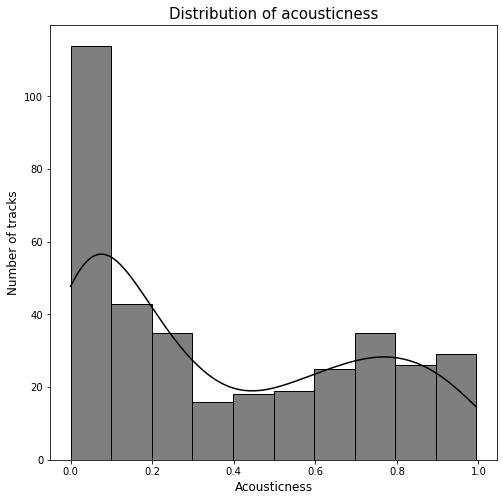

In [43]:
plt.figure(figsize=(8, 8))
sns.histplot(data=df2, x="acousticness", color="#000000", kde=True)
plt.title("Distribution of acousticness", fontsize=15)
plt.xlabel("Acousticness", fontsize=12)
plt.ylabel("Number of tracks", fontsize=12)
plt.show()

For a large number of tracks (100+), there is very low confidence (close to 0) for acousticness. This means that there are only a limited number of acoustic tracks in the dataset.

**Instrumentalness** _predicts whether a track contains no vocals. “Ooh” and “aah” sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly “vocal”. The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0._

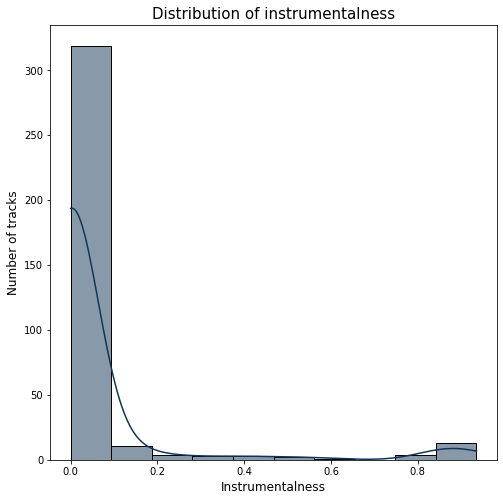

In [44]:
plt.figure(figsize=(8, 8))
sns.histplot(data=df2, x="instrumentalness", color="#123456", kde=True, bins=10)
plt.title("Distribution of instrumentalness", fontsize=15)
plt.xlabel("Instrumentalness", fontsize=12)
plt.ylabel("Number of tracks", fontsize=12)
plt.show()

Almost all the tracks have instrumentalness 0 or close to 0, hence the plot appears to be blank unless a small number of bins (e.g. 10) is specified. This is expected, since most of my tracks contain vocals.

**Liveness** _detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live._

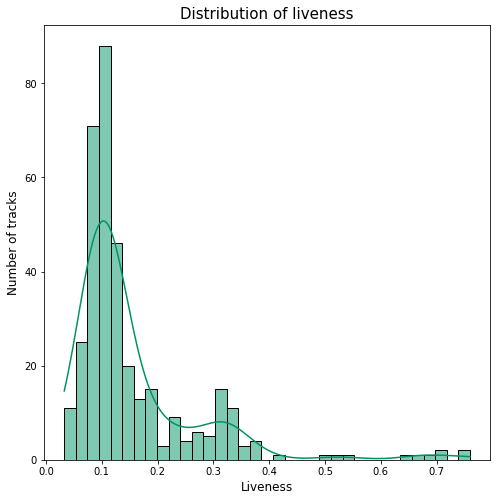

In [45]:
plt.figure(figsize=(8, 8))
sns.histplot(data=df2, x="liveness", color="#009265", kde=True)
plt.title("Distribution of liveness", fontsize=15)
plt.xlabel("Liveness", fontsize=12)
plt.ylabel("Number of tracks", fontsize=12)
plt.show()

Most tracks in our dataset have negligible likelihood of being live, i.e. they are almost all studio-recorded.

**Valence** is _a measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry)._

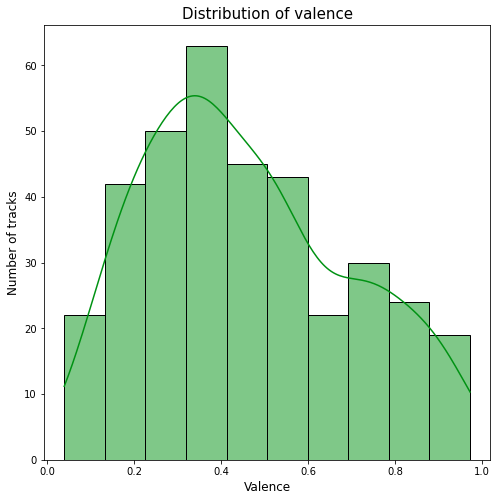

In [46]:
plt.figure(figsize=(8, 8))
sns.histplot(data=df2, x="valence", color="#009213", kde=True)
plt.title("Distribution of valence", fontsize=15)
plt.xlabel("Valence", fontsize=12)
plt.ylabel("Number of tracks", fontsize=12)
plt.show()

The valence scores are more evenly distributed compared to other audio features, although there is of a peak around 0.4, which suggests a moderately low level of "cheerfulness" in the tracks.

**Tempo** is _the overall estimated tempo of a track in beats per minute (BPM). In musical terminology, tempo is the speed or pace of a given piece and derives directly from the average beat duration._

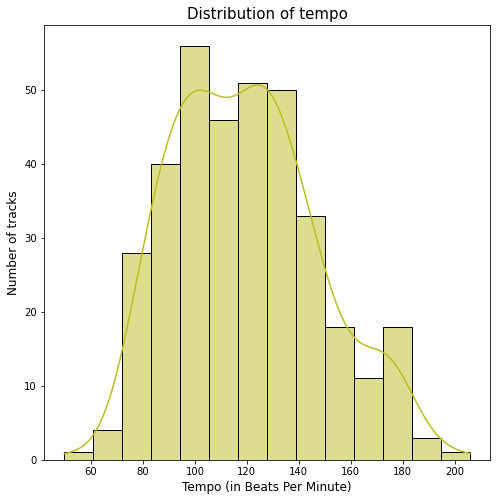

In [47]:
plt.figure(figsize=(8, 8))
sns.histplot(data=df2, x="tempo", color="tab:olive", kde=True)
plt.title("Distribution of tempo", fontsize=15)
plt.xlabel("Tempo (in Beats Per Minute)", fontsize=12)
plt.ylabel("Number of tracks", fontsize=12)
plt.show()

The tempo follows a normal-like distribution again, but slightly skewed to the left. 100-140 BPM is the range with the most number of tracks.

_The **time signature** (meter) is a notational convention to specify how many beats are in each bar (or measure)._

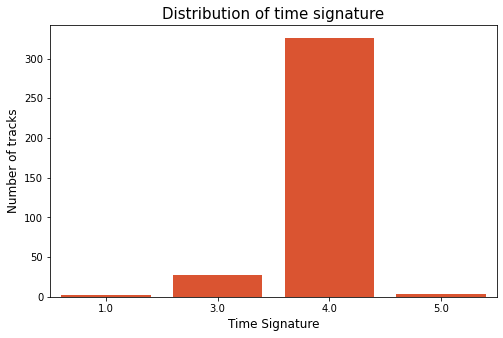

In [48]:
plt.figure(figsize=(8, 5))
sns.countplot(x="time_signature", data=df2, color="#F64415")
plt.title("Distribution of time signature", fontsize=15)
plt.xlabel("Time Signature", fontsize=12)
plt.ylabel("Number of tracks", fontsize=12)
plt.show()

The vast majority of tracks have a time signature of 4, which is indeed quite common in pop songs.

Now that we have over 7 times the number of rows compared to `df1`, it would be interesting to see if the correlation between audio features shows any significant differences. Similar to Task 3.1 (iv), we will compute the pairwise correlation for the track popularity, duration and audio features.

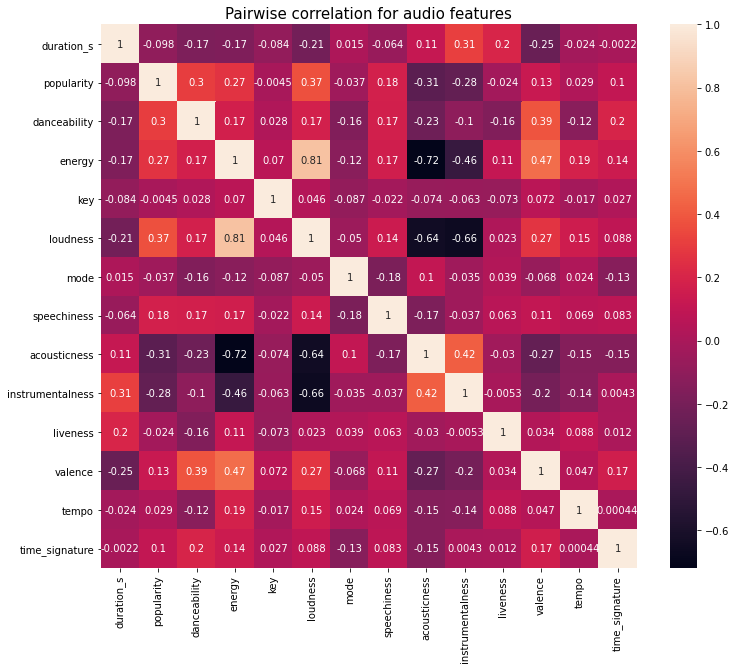

In [49]:
plt.figure(figsize=(12, 10))
sns.heatmap(df2.iloc[:, 5:].corr(), annot=True)
plt.title("Pairwise correlation for audio features", fontsize=15)
plt.show()

As before,
- Energy and loudness have a strong positive correlation (0.81).
- Energy and valence have a weak to moderate positive correlation (0.47).

This suggests that energy, loudness and valence usually go hand in hand, with an increase in one quite possibly suggesting an increase the other. 

Some pairs behave slightly differently to before:
- Popularity and danceability now only have a weak positive correlation of 0.3, suggesting that less danceable or energetic tracks can also gain or lose popularity. I believe this generally varies with personal preferences. 
- The negative correlation between the pairs (energy, acousticness), (energy, instrumentalness), (loudness, acousticness), (loudness, instrumentalness) is much more pronounced than before. This trend reaffirms the tendency of acoustic or instrumental tracks to be more calming, with limited "energy" and "loudness".

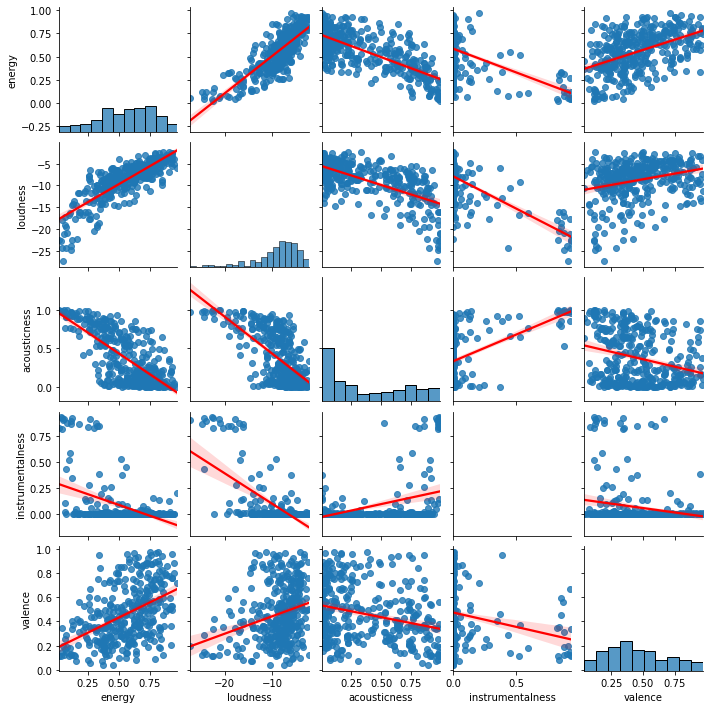

In [50]:
sns.pairplot(df2[["energy", "loudness", "acousticness", "instrumentalness",
                  "valence"]], height=2, kind="reg", plot_kws={'line_kws': {'color': 'red'}})
plt.show()

The scatter matrix above summarises the distribution and relationships between some of the audio features we've seen (i.e. the ones that have shown moderate to strong correlation in our heatmap earlier).
The regression lines are helpful in telling at a glance whether the pair of features has a positive or negative slope, and consequently correlation. The magnitude of the slope indicates the strength of the correlation.

### Summary

- The median popularity of my top 50 tracks is 57 out of 100, which suggests that a large number of tracks that I enjoy are still undiscovered by a lot of people in Ireland!
- The duration of a track has negligible correlation with its popularity.
- Most of my top tracks were released in the late 2010's but there's also a good number of classic tracks from the 1960's and 70's.
- My top 3 artists are The Beatles, The Lumineers and Gregory Alan Isakov.
- The majority of current top 10 tracks of my top artists have been released recently (mostly in the last 5 years, with over 50 of them in 2020 itself), suggesting that newer tracks gain more popularity on Spotify.
- Energy and loudness of a track have a strong positive correlation, and these two features also share a moderately strong positive correlation with valence.
- Acousticness/instrumentalness both have a moderately strong negative correlation with energy/loudness/valence.

As always, the story told here might as well reveal some plot twists upon further analysis. There is always room for more questions, and without further exploration, we can only imagine what the answers might look like. The following are a few possible questions that currently remain unanswered:

- What are the music genres that current my top tracks and artists on Spotify are associated with? Is there wide range of such genres, or are some particular ones more popular than others?
- If data is collected for a much larger number of tracks, do some of the audio features indicate a stronger or weaker pairwise correlation that is not evident with our current limited dataset?
- What kind of results would we get by comparing the top tracks and artists for multiple Spotify users? 
- Would it be possible to design a fairly accurate machine learning model, using the wide range of audio features, to estimate the likelihood of a user liking a particular track?
- What kind of tracks is a particular user likely to group together in a playlist? Are there any common features for tracks in particular playlist?
- The Spotify API has an endpoint to fetch related artists. What makes two or more artists similar? 
- The API also has endpoints for shows (podcasts) and their episodes. What kind of insights could be gathered by exploring these paths?

I would definitely like to explore some of these questions in the future, especially to see if I can design a reliable machine learning model that can predict whether I will enjoy a new song, similar to the algorithms Spotify itself uses to suggest new songs to a user!